## A mission to automate monitoring of flowering

In this notebook, we will create a flower type identification system by implementing a model that classifies images employing multiple convolutional **filters** for multi-**channel**/RGB images, adding **padding** to images to preserve image sizes/capture edge data, determining the best **stride** to use with the convolutional filters, passing that data through **activation functions** such as ReLU and **pooling** layers, and **flattenning** our results to obtain classes using **categorical cross entropy**.


### Importing Required Libraries



In [ ]:
import warnings
warnings.simplefilter('ignore')

import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Classifying Flowers


We will use our flower images from the image convolution lab to use them to train a CNN model for classification. Hence, we will utilize a training and test set.
https://www.tensorflow.org/tutorials/load_data/images


### Importing data

Lets take a look at the flowers dataset from tensorflow, retrieved from here: [https://www.tensorflow.org/datasets/catalog/tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In [ ]:
#!pip install skillsnetwork

# import skillsnetwork

# dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/flower_photos.tgz"
# await skillsnetwork.prepare(dataset_url, overwrite=True)

In [ ]:
data_dir = Path("flower_photos")

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The dandelion folder has 898 pictures
The roses folder has 641 pictures
The tulips folder has 799 pictures
The daisy folder has 633 pictures
The sunflowers folder has 699 pictures
3670 total images


Let's extract some images we can use for this lab. We will set them all to be square images of 300x300, and display them as well.


In [ ]:
img_width = 150
img_height = 150

batch_size = 64
epochs = 10

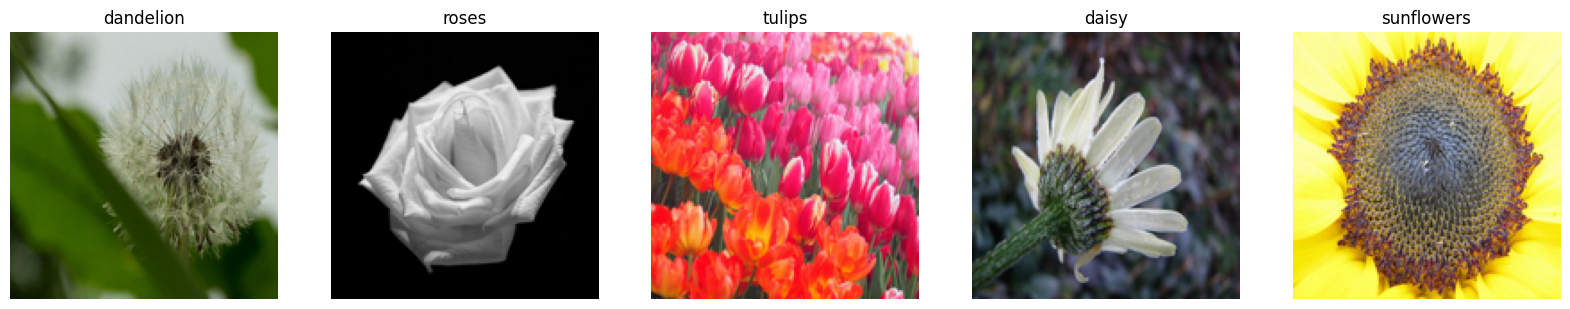

In [ ]:
# Plotting out some images we have
pics = list()
pics_arr = list()
p_class = list()

plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)


Let's create a train set using the `ImageDataGenerator` and `flow_from_directory` functions from `keras.utils`.


In [ ]:
train_gen = ImageDataGenerator(validation_split=0.2,
                               rescale=1.0/255.0,
                                width_shift_range=0.2, # 0.2
                                height_shift_range=0.2, # 0.2
                                horizontal_flip=True)
train_set = train_gen.flow_from_directory(
                               directory=data_dir,
                               seed=10,
                               class_mode='sparse',
                               batch_size=batch_size,
                               shuffle=True,
                               target_size=(img_height, img_width),
                               subset='training')

Found 2939 images belonging to 5 classes.


#### Create validation set by setting **subset = 'validation'**


In [ ]:
## Create a validation set using the same way, labelling subset as "validation"
validation_gen = ImageDataGenerator(validation_split=0.2,
                               rescale=1.0/255.0,
                                width_shift_range=0.2, # 0.2
                                height_shift_range=0.2, # 0.2
                                horizontal_flip=True)
validation_set = validation_gen.flow_from_directory(
                               directory=data_dir,
                               seed=10,
                               class_mode='sparse',
                               batch_size=batch_size,
                               shuffle=True,
                               target_size=(img_height, img_width),
                               subset='validation')


Found 731 images belonging to 5 classes.


This creates a dictionary which we can use to look up the name of the flower type according to its label number.


In [ ]:
class_names = {y: x for x, y in validation_set.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

### Building a classifier


####  Define the first set of convolutional layers


1. Convolutional layer with input depth equal to 3, 32 5x5 filters, even padding, and relu activation function.
2. Max pooling layer with size 2x2.
3. Convolutional layer with 64 3x3 filters, padding, and relu activation function.
4. Max pooling layer with size 2x2, strides of 2 horizontally and vertically.
5. Convolutional layer with 32 3x3 filters, even padding, and relu activation function.
6. Max pooling layer with size 2x2, strides of 2 horizontally and vertically.
7. Convolutional layer with 32 3x3 filters, padding, and relu activation function.
8. Max pooling layer with size 2x2, strides of 2 horizontally and vertically.
9. Dense layer with 512 units and relu activation function.
10. Dense layer with 5 units (because the dataset has 5 classes) and softmax activation function.


In [ ]:
classifier = Sequential()

classifier.add(Conv2D(32,(5,5),activation='relu',padding="same",input_shape=(img_width,img_height,3)))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Conv2D(64,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

classifier.add(Conv2D(32,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
classifier.add(Conv2D(32,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

classifier.add(Flatten())
classifier.add(Dense(512,activation='relu'))
classifier.add(Dense(5,activation='softmax'))

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 32)        0

### Prediction!

We compile the model using the Adam optimizer, categorical cross entropy as the loss function, and measuring performance based on its accuracy.


In [ ]:
classifier.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
classifier.fit(
  train_set,
  validation_data=validation_set,
  epochs=epochs
)

Epoch 1/10
46/46 [==============================] - 208s 4s/step - loss: 1.3126 - accuracy: 0.4124 - val_loss: 1.2547 - val_accuracy: 0.5007
Epoch 2/10
46/46 [==============================] - 202s 4s/step - loss: 1.1127 - accuracy: 0.5662 - val_loss: 1.1817 - val_accuracy: 0.5280
Epoch 3/10
46/46 [==============================] - 199s 4s/step - loss: 1.0043 - accuracy: 0.6172 - val_loss: 1.0235 - val_accuracy: 0.5992
Epoch 4/10
46/46 [==============================] - 202s 4s/step - loss: 0.9341 - accuracy: 0.6393 - val_loss: 0.9481 - val_accuracy: 0.6115
Epoch 5/10
46/46 [==============================] - 205s 4s/step - loss: 0.8904 - accuracy: 0.6482 - val_loss: 0.9318 - val_accuracy: 0.6621
Epoch 6/10
46/46 [==============================] - 205s 4s/step - loss: 0.8618 - accuracy: 0.6645 - val_loss: 0.9330 - val_accuracy: 0.6279
Epoch 7/10
46/46 [==============================] - 201s 4s/step - loss: 0.8070 - accuracy: 0.6883 - val_loss: 0.8985 - val_accuracy: 0.6484
Epoch 8/10
46

### with 67 % accuracy against the validation set our model in not that bad.

Let's predict the label for a sample image **img_tensor**.


1/1 [==============================] - 0s 56ms/step


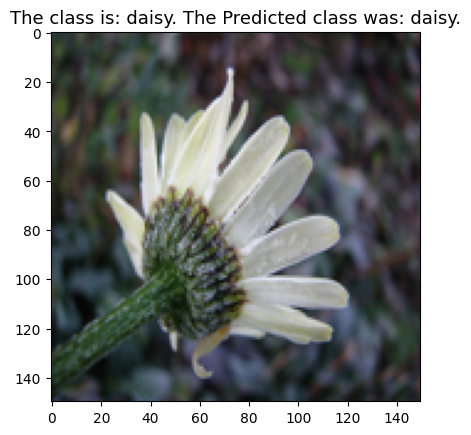

In [ ]:
img_tensor = pics_arr[3]
img_class = p_class[3]
img_tensor = np.expand_dims(img_tensor, axis=0)

y = classifier.predict(img_tensor)
label = class_names[np.argmax(y)]

plt.imshow(img_tensor.reshape((img_width,img_height,3)).astype("uint8"))
plt.title(f"The class is: {img_class}. The Predicted class was: {label}.", fontsize=13)

plt.show()

Let us pick another more complicated image and see if we can predict it.

1/1 [==============================] - 0s 137ms/step


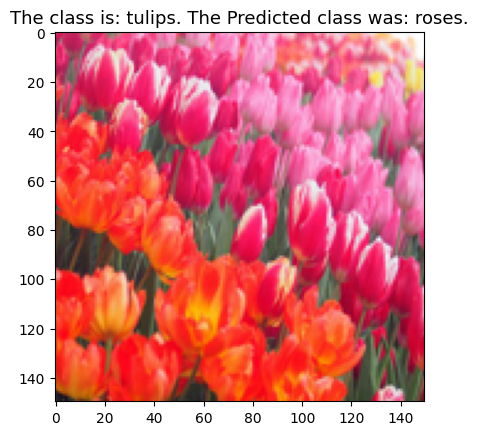

In [ ]:
img_tensor = pics_arr[2]
img_class = p_class[2]
img_tensor = np.expand_dims(img_tensor, axis=0)

y = classifier.predict(img_tensor)
label = class_names[np.argmax(y)]

plt.imshow(img_tensor.reshape((img_width,img_height,3)).astype("uint8"))
plt.title(f"The class is: {img_class}. The Predicted class was: {label}.", fontsize=13)

plt.show()


Indee that was a difficult case. The class predicted, roses, was probably due to the predominance of red in the image.